In [35]:
# В данной задаче мы будем проводить анализ того, различаются ли между собой дизайны лайков (красный, синий и зеленый)
# Так как у нас больше 2-х сравниваемых значений, то мы будем использовать не t-test, а F-статистику (дисперсионный анализ)

In [1]:
import pandas as pd
import numpy as np 


import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from scipy.special import comb

import pingouin as pg

import seaborn as sns 
import matplotlib.pyplot as plt

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# считываем данные

In [3]:
post_likes = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-gadzhimuradov/kc_stata/post_likes.csv', sep = ';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
post_likes

,id,button,likes
0,S001,red,160
1,S002,red,150
2,S003,red,150
3,S004,red,150
4,S005,red,187
...,...,...,...
295,S296,blue,196
296,S297,blue,252
297,S298,blue,194
298,S299,blue,185


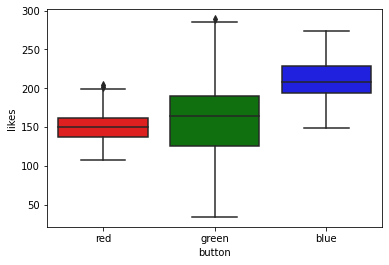

In [5]:
sns.boxplot(x = 'button', y = 'likes', data = post_likes, palette = ['r', 'g', 'b'])

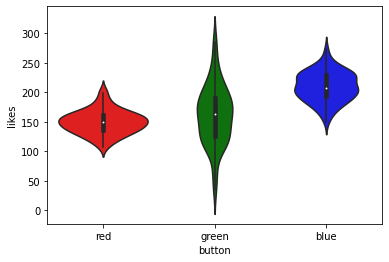

In [6]:
sns.violinplot(x = 'button', y = 'likes', data = post_likes, palette = ['r', 'g', 'b'])

In [7]:
# Создаем нужные нам массивы данных

In [8]:
red = post_likes.query("button == 'red'").likes
green = post_likes.query("button == 'green'").likes
blue = post_likes.query("button == 'blue'").likes

In [9]:
# Проводим сравнение

In [10]:
ss.f_oneway(red, green, blue)

F_onewayResult(statistic=85.99631112614011, pvalue=3.4370045810218544e-30)

In [11]:
# f статистика равна 86, что означает что межгрупповая дисперсия в 86 раз больше чем внутригрупповая
# pvalue намного меньше чем 0.05, следовательно мы отклоняем нулевую гипотезу и принимаем альтернативную
# альтернативная гипотеза подразумевает, что выборочные средние значительно отличаются друг от друга

In [12]:
# Перейдем к более подробному варианту дисперсионного анализа (через пакет statsmodels)

In [13]:
model = smf.ols(formula = "likes ~ C(button)", data = post_likes).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(button),2.0,201960.286667,100980.143333,85.996311,3.437005e-30
Residual,297.0,348748.710000,1174.238081,NaN,NaN


In [14]:
# Получили более детальный анализ, PR(>F) - это наше pvalue

In [15]:
# Есть еще один способ это рассчитать (через пакет Pingouin)

In [16]:
pg.anova(data = post_likes, dv = 'likes', between = 'button')

,Source,ddof1,ddof2,F,p-unc,np2
0,button,2,297,85.996311,3.437005e-30,0.366728


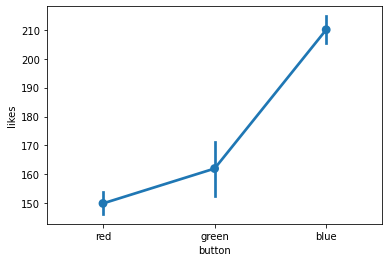

In [17]:
sns.pointplot(x = 'button', y = 'likes', data = post_likes)

In [18]:
# мы видим, что голубая кнопка показывает самый лучший результат, 
# затем идет зеленая кнопка, ну, а самый худший результат показала красная кнопка

In [19]:
# тестиуем нормальность наших данных

In [20]:
print(ss.normaltest(red))
print(ss.normaltest(green))
print(ss.normaltest(blue))

NormaltestResult(statistic=1.8343585907539965, pvalue=0.3996447324611219)
NormaltestResult(statistic=0.6727062715909409, pvalue=0.7143707913703767)
NormaltestResult(statistic=0.4606964500747045, pvalue=0.7942569741771747)


In [21]:
pg.normality(data = post_likes, dv = 'likes', group = 'button', method = 'normaltest')

,W,pval,normal
red,1.834359,0.399645,True
green,0.672706,0.714371,True
blue,0.460696,0.794257,True


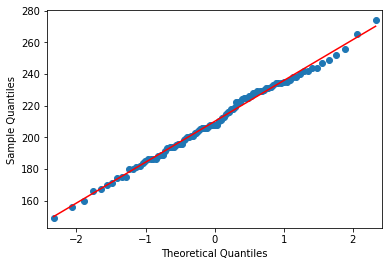

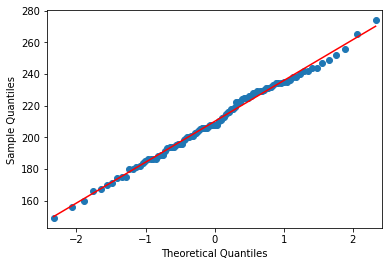

In [22]:
sm.qqplot(blue, line = 'r')

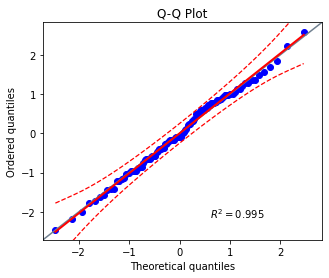

In [23]:
pg.qqplot(blue)

In [24]:
# Теперь тестируем различие в дисперсиях

In [25]:
# сделаем через scipy
ss.levene(red, green, blue)

LeveneResult(statistic=35.214282435572876, pvalue=1.8886636651084242e-14)

In [26]:
# сделаем через pinqouin
pg.homoscedasticity(data = post_likes, dv = 'likes', group = 'button')

,W,pval,equal_var
levene,35.214282,1.888664e-14,False


In [27]:
# 1.8886636651084242e-14 это значение показывает нам, что наши диспресии во всех группах разные

In [28]:
# В таком случае нам нужно сделать анализ Уэлча

In [29]:
pg.welch_anova(data = post_likes, dv = 'likes', between = 'button')

,Source,ddof1,ddof2,F,p-unc,np2
0,button,2,182.958104,177.856578,1.255660e-43,0.366728


In [30]:
# Теперь разберем проблему множественных сравнений

In [32]:
# попарные сравнения без поправки
pg.pairwise_ttests(data = post_likes, dv = 'likes', between = 'button')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,button,blue,green,False,True,8.591097,198.0,two-sided,2.561866e-15,2.025e+12,1.210357
1,button,blue,red,False,True,18.769214,198.0,two-sided,7.952330e-46,1.582e+42,2.644301
2,button,green,red,False,True,2.240189,198.0,two-sided,2.619001e-02,1.583,0.315609


In [36]:
# указывается группы A и B (их сравниваем)
# видим что по колонке pvalue (p-unc) зеленая и синяя + синяя и красная сущесвтенно значимые (т.е явно отличаются)

In [37]:
2.619001e-02

0.02619001

In [38]:
# и получается что зеленая и красная пара тоже отличается

In [39]:
# Останутся ли между ними значимые различия если мы сделаем поправку? 

In [40]:
# с поправкой Бонферонни
pg.pairwise_ttests(data = post_likes, dv = 'likes', between = 'button', padjust = 'bonf')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,button,blue,green,False,True,8.591097,198.0,two-sided,2.561866e-15,7.685599e-15,bonf,2.025e+12,1.210357
1,button,blue,red,False,True,18.769214,198.0,two-sided,7.952330e-46,2.385699e-45,bonf,1.582e+42,2.644301
2,button,green,red,False,True,2.240189,198.0,two-sided,2.619001e-02,7.857004e-02,bonf,1.583,0.315609


In [42]:
7.857004e-02

0.07857004

In [43]:
# Теперь p значение = 7.857004e-02 и теперь мы видим что пара зеленая и красная не отличаются друг от друга существенно

In [45]:
# Поправка Холма
pg.pairwise_ttests(data = post_likes, dv = 'likes', between = 'button', padjust = 'holm')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,button,blue,green,False,True,8.591097,198.0,two-sided,2.561866e-15,5.123733e-15,holm,2.025e+12,1.210357
1,button,blue,red,False,True,18.769214,198.0,two-sided,7.952330e-46,2.385699e-45,holm,1.582e+42,2.644301
2,button,green,red,False,True,2.240189,198.0,two-sided,2.619001e-02,2.619001e-02,holm,1.583,0.315609


In [46]:
# тест Тьюки
pg.pairwise_tukey(data = post_likes, dv = 'likes', between = 'button')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,blue,green,210.03,162.02,48.01,4.846108,9.906919,0.001000,1.395736
1,blue,red,210.03,149.96,60.07,4.846108,12.395514,0.001000,1.746342
2,green,red,162.02,149.96,12.06,4.846108,2.488595,0.035581,0.350606


In [48]:
# тест Геймса-Хоувелла
pg.pairwise_gameshowell(data = post_likes, dv = 'likes', between = 'button')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,blue,green,210.03,162.02,48.01,5.588343,8.591097,145.583529,0.001000,1.210357
1,blue,red,210.03,149.96,60.07,3.200454,18.769214,188.902921,0.001000,2.644301
2,green,red,162.02,149.96,12.06,5.383475,2.240189,129.889834,0.068387,0.315609


In [49]:
pairwise_tukeyhsd(post_likes.likes, post_likes.button).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
blue,green,-48.01,0.001,-59.4257,-36.5943,True
blue,red,-60.07,0.001,-71.4857,-48.6543,True
green,red,-12.06,0.0356,-23.4757,-0.6443,True


In [50]:
MultiComparison(post_likes.likes, post_likes.button).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
blue,green,-48.01,0.001,-59.4257,-36.5943,True
blue,red,-60.07,0.001,-71.4857,-48.6543,True
green,red,-12.06,0.0356,-23.4757,-0.6443,True
